In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from tqdm import tqdm
import librosa

# Prepare train-dev-test

In [2]:
root_path=Path("/media/ben/datadrive/Zalo/voice-verification/")
files = list(root_path.joinpath(Path("./Train-Test-Data/dataset/")).glob("./*/*.wav"))
paths = [f for f in files]
filenames = [f.name for f in files]
speaker_ids = [str(f.parents[0].name) for f in files]
uri = [str(f.parents[0].name) + "_" + str(f.stem) for f in files]
_, y_true = np.unique(speaker_ids, return_inverse=True)
df = pd.DataFrame({"filenames": filenames, "speaker_id": speaker_ids, "uri": uri, "path": paths, "y_true": y_true})

np.random.seed(0)
print("Number of unique speakers:", len(df["y_true"].unique()))

y_true_unique = df["y_true"].unique()
dataX = y_true_unique.copy()
test_len = int(round(len(y_true_unique)*0.1))
dev_len = int(round(len(y_true_unique)*0.1))
train_len = int(round(len(y_true_unique)*0.8))

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(dataX, y_true_unique, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


print(len(y_train), len(y_val), len(y_test))
#np.random.shuffle(y_true_unique)
#y_true_unique
y_train_speakers = y_true_unique[0:320]
y_val_speakers = y_true_unique[320:360]
y_test_speakers = y_true_unique[360:]
df_train = df[df["y_true"].isin(y_train_speakers)]
df_val = df[df["y_true"].isin(y_val_speakers)]
df_test = df[df["y_true"].isin(y_test_speakers)]
print(len(df_train), len(df_val), len(df_test))

Number of unique speakers: 400
320 40 40
8533 990 1033


# Prepare the speaker verification expts in each train-dev-test

In [3]:
pd.options.mode.chained_assignment = None
def generate_verfication_trials_df(inplace_df):
    np.random.seed(0)
    row = {}
    with tqdm(total=len(inplace_df)) as pbar:
        for i, group in inplace_df.groupby("y_true"):
            num_samples_this_speaker = len(group)
            current_speaker_id_of_group = group.y_true.unique()[0]
            for i, (index, row) in enumerate(group.iterrows()):
                # For the first half of the group, pair with a random item from the group
                # For the second half of the group, pair with a random item not in the group
                if i > round(num_samples_this_speaker/2.):
                    sample = inplace_df[inplace_df["y_true"] == current_speaker_id_of_group].sample()
                    audio2_path = sample.iloc[0]["path"]
                    audio2_label = sample.iloc[0]["y_true"]
                    audio2_uri = sample.iloc[0]["uri"]
                else:
                    sample = inplace_df[inplace_df["y_true"] != current_speaker_id_of_group].sample()
                    audio2_path = sample.iloc[0]["path"]
                    audio2_label = sample.iloc[0]["y_true"]
                    audio2_uri = sample.iloc[0]["uri"]
                inplace_df.loc[index, "audio2_path"] = audio2_path
                inplace_df.loc[index, "audio2_label"] = audio2_label
                inplace_df.loc[index, "audio2_uri"] = audio2_uri
                pbar.update()
    inplace_df["y_comparison"] = inplace_df["y_true"] == inplace_df["audio2_label"]
    
    return inplace_df

    
pd.set_option('display.min_rows', 10)
print("Preparing train")
df_train = generate_verfication_trials_df(df_train)
print("Preparing val")
df_val = generate_verfication_trials_df(df_val)
print("Preparing test")
df_test = generate_verfication_trials_df(df_test)

def get_duration(path):
    duration = librosa.get_duration(filename=path)
    return duration
df_train.loc[:, "duration"] = df_train["path"].apply(get_duration)
df_train.loc[:, "audio2_duration"] = df_train["audio2_path"].apply(get_duration)
df_val.loc[:, "duration"] = df_val["path"].apply(get_duration)
df_val.loc[:, "audio2_duration"] = df_val["audio2_path"].apply(get_duration)
df_test.loc[:, "duration"] = df_test["path"].apply(get_duration)
df_test.loc[:, "audio2_duration"] = df_test["audio2_path"].apply(get_duration)

pd.options.mode.chained_assignment = "warn"

  0%|          | 33/8533 [00:00<00:26, 323.89it/s]

Preparing train


  5%|▌         | 54/990 [00:00<00:01, 532.93it/s]

Preparing val


  5%|▌         | 53/1033 [00:00<00:01, 520.09it/s]

Preparing test


100%|██████████| 1033/1033 [00:01<00:00, 535.15it/s]


In [8]:
df_train["path"]

,filenames,speaker_id,uri,path,y_true,rttm,uem,audio2_path,audio2_label,audio2_uri,y_comparison
0,747-8.wav,747-F-31,747-F-31_747-8,/media/ben/datadrive/Zalo/voice-verification/T...,307,SPEAKER 747-F-31/747-8 1 0 0.9923958333333334 ...,747-F-31/747-8 NA 0.000 0.9923958333333334\n,/media/ben/datadrive/Zalo/voice-verification/T...,392.0,81-F-31_81-4,False
1,747-10.wav,747-F-31,747-F-31_747-10,/media/ben/datadrive/Zalo/voice-verification/T...,307,SPEAKER 747-F-31/747-10 1 0 1.4780416666666667...,747-F-31/747-10 NA 0.000 1.4780416666666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,86.0,444-F-27_444-25,False
2,747-15.wav,747-F-31,747-F-31_747-15,/media/ben/datadrive/Zalo/voice-verification/T...,307,SPEAKER 747-F-31/747-15 1 0 0.8234791666666667...,747-F-31/747-15 NA 0.000 0.8234791666666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,35.0,70-M-38_70-12,False
3,747-3.wav,747-F-31,747-F-31_747-3,/media/ben/datadrive/Zalo/voice-verification/T...,307,SPEAKER 747-F-31/747-3 1 0 6.249979166666667 <...,747-F-31/747-3 NA 0.000 6.249979166666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,47.0,646-M-31_646-11,False
4,747-7.wav,747-F-31,747-F-31_747-7,/media/ben/datadrive/Zalo/voice-verification/T...,307,SPEAKER 747-F-31/747-7 1 0 1.0768541666666667 ...,747-F-31/747-7 NA 0.000 1.0768541666666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,223.0,428-M-25_428-18,False
...,...,...,...,...,...,...,...,...,...,...,...
8528,642-17.wav,642-F-32,642-F-32_642-17,/media/ben/datadrive/Zalo/voice-verification/T...,216,SPEAKER 642-F-32/642-17 1 0 1.4369375 <NA> <NA...,642-F-32/642-17 NA 0.000 1.4369375\n,/media/ben/datadrive/Zalo/voice-verification/T...,216.0,642-F-32_642-17,True
8529,642-2.wav,642-F-32,642-F-32_642-2,/media/ben/datadrive/Zalo/voice-verification/T...,216,SPEAKER 642-F-32/642-2 1 0 1.3219791666666667 ...,642-F-32/642-2 NA 0.000 1.3219791666666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,216.0,642-F-32_642-11,True
8530,642-9.wav,642-F-32,642-F-32_642-9,/media/ben/datadrive/Zalo/voice-verification/T...,216,SPEAKER 642-F-32/642-9 1 0 2.557729166666667 <...,642-F-32/642-9 NA 0.000 2.557729166666667\n,/media/ben/datadrive/Zalo/voice-verification/T...,216.0,642-F-32_642-17,True
8531,642-6.wav,642-F-32,642-F-32_642-6,/media/ben/datadrive/Zalo/voice-verification/T...,216,SPEAKER 642-F-32/642-6 1 0 5.431604166666666 <...,642-F-32/642-6 NA 0.000 5.431604166666666\n,/media/ben/datadrive/Zalo/voice-verification/T...,216.0,642-F-32_642-12,True


In [4]:
df_train.to_csv("df_train.csv")
df_val.to_csv("df_val.csv")
df_test.to_csv("df_test.csv")

# Prepare pyannote specific files for train/dev/test

In [6]:
def uri_gen(row):
    return row["speaker_id"] + "/" + row['filenames'].split(".")[0]

def create_rrtm_row(row):
    duration = librosa.get_duration(filename=row["path"])
    uri_filename = uri_gen(row)
    row = f"SPEAKER {uri_filename} 1 {0} {duration} <NA> <NA> {row['speaker_id']} <NA> <NA>\n" 
    return row

def create_uem_row(row):
    duration = librosa.get_duration(filename=row["path"])
    uri_filename = uri_gen(row)
    row = f"{uri_filename} NA 0.000 {duration}\n"
    return row

df_train["rttm"] = df_train.apply(create_rrtm_row, axis=1)
df_train["uem"] = df_train.apply(create_uem_row, axis=1)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/train.rttm")), "w") as filehandle:
    for row in df_train["rttm"].values:
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/train.uem")), "w") as filehandle:
    for row in df_train["uem"].values:
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/train.lst")), "w") as filehandle:
    for _, row in df_train.iterrows():
        row = uri_gen(row) + "\n"
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/train.trial")), "w") as filehandle:
    for index, row in df_train.iterrows():
        audio1 = row["speaker_id"] + "/" + row['filenames'].split(".")[0]
        audio2 = row["audio2_path"].parents[0].stem + "/" + row["audio2_path"].stem
        row = f"{int(row['y_comparison'])} {audio1} {audio2}\n"
        filehandle.write(row)
        
df_val["rttm"] = df_val.apply(create_rrtm_row, axis=1)
df_val["uem"] = df_val.apply(create_uem_row, axis=1)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/development.rttm")), "w") as filehandle:
    for row in df_val["rttm"].values:
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/development.uem")), "w") as filehandle:
    for row in df_val["uem"].values:
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/development.lst")), "w") as filehandle:
    for _, row in df_val.iterrows():
        row = uri_gen(row) + "\n"
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/development.trial")), "w") as filehandle:
    for index, row in df_val.iterrows():
        audio1 = row["speaker_id"] + "/" + row['filenames'].split(".")[0]
        audio2 = row["audio2_path"].parents[0].stem + "/" + row["audio2_path"].stem
        row = f"{int(row['y_comparison'])} {audio1} {audio2}\n"
        filehandle.write(row)
    
df_test["rttm"] = df_test.apply(create_rrtm_row, axis=1)
df_test["uem"] = df_test.apply(create_uem_row, axis=1)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/test.rttm")), "w") as filehandle:
    for row in df_test["rttm"].values:
        filehandle.write(row)  
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/test.uem")), "w") as filehandle:
    for row in df_val["uem"].values:
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/test.lst")), "w") as filehandle:
    for _, row in df_test.iterrows():
        row = uri_gen(row) + "\n"
        filehandle.write(row)
with open(root_path.joinpath(Path("pyannote_db_files/ZALODATASET/test.trial")), "w") as filehandle:
    for index, row in df_test.iterrows():
        audio1 = row["speaker_id"] + "/" + row['filenames'].split(".")[0]
        audio2 = row["audio2_path"].parents[0].stem + "/" + row["audio2_path"].stem
        row = f"{int(row['y_comparison'])} {audio1} {audio2}\n"
        filehandle.write(row)

    

/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

# Load train/dev/test

In [3]:
df_val = pd.read_csv("df_val.csv")

# Load existing embeddings

In [4]:
Xemb = np.load('embeddings_voxceleb_20epochfinetuned.npy')
speaker_ids = np.load("speaker_ids.npy")
uris = np.load("uris.npy")
_, y_true = np.unique(speaker_ids, return_inverse=True)
#df_data = pd.DataFrame({"speaker_ids": speaker_ids, "y_true": y_true, "uris": uris})
#df_data
#Xemb[np.where(uris == "747-F-31_747-10")].shape
def get_emb_with_uri(uri):
    return Xemb[np.where(uris == uri)]


FileNotFoundError: [Errno 2] No such file or directory: 'embeddings_voxceleb_20epochfinetuned.npy'

In [ ]:
def populate_df_distance_field(row):
    audio1 = get_emb_with_uri(row["uri"])
    audio2 = get_emb_with_uri(row["audio2_uri"])
    distance = cdist(audio1, audio2, metric="cosine")
    return distance[0][0]

def get_dist_then_accuracy(df):
    df.loc[:, "dist"] = df.apply(populate_df_distance_field, axis=1)
    fpr, tpr, thresholds = roc_curve(df["y_comparison"], df["dist"])
    accuracy_scores = []
    for thresh in thresholds:
        accuracy_scores.append(accuracy_score(df["y_comparison"], 
                                             [1 if dist < thresh else 0 for dist in df["dist"].values]))

    accuracies = np.array(accuracy_scores)
    max_accuracy = accuracies.max() 
    max_accuracy_threshold =  thresholds[accuracies.argmax()]
    return accuracies, max_accuracy, max_accuracy_threshold

accuracies, max_accuracy, max_accuracy_threshold = get_dist_then_accuracy(df_val)
pd.DataFrame(accuracies).hist(bins=100)

In [34]:
# AMI pretrained 0.79 accuracy, 0.60877695242878 best threshold
# Voxceleb pretrained 0.8645 accuracy, 0.567065120412566 best threshold
# After 20 epochs --> (0.9285128325325208, 0.7331345786833539) but thats including data leakage as its on the data it was trained on.
max_accuracy, max_accuracy_threshold


(0.908080808080808, 0.7003636259184187)

# Choose a threshold that gives best balance between + and -

In [39]:
def get_optimal_balanced_threshold(df):
    rows = []
    for i in np.arange(0, 1, 0.001):
        result = (df["dist"] < i).value_counts()
        if len(result) == 1:
            # If only True or False then its a bad threshold and move on
            continue
        ratio = result.loc[True] / result.loc[False] 
        minimise_metric = abs((ratio) -1)
        rows.append({"metric": minimise_metric, "threshold":i, "ratio": ratio})
    _ = pd.DataFrame(rows)
    return _.sort_values("metric").iloc[0]
get_optimal_balanced_threshold(df_train)

metric       0.000703
threshold    0.792000
ratio        0.999297
Name: 791, dtype: float64

# Below is experimental scratch work

In [21]:
df_train["duration"], df_train["audio2_duration"], df_train["y_comparison"]

(0       0.992396
 1       1.478042
 2       0.823479
 3       6.249979
 4       1.076854
           ...   
 8528    1.436937
 8529    1.321979
 8530    2.557729
 8531    5.431604
 8532    0.689729
 Name: duration, Length: 8533, dtype: float64,
 0        2.198917
 1        2.744687
 2        1.655083
 3        1.593667
 4       13.368021
           ...    
 8528     1.580625
 8529     1.321979
 8530     1.580625
 8531     6.437458
 8532     2.931333
 Name: audio2_duration, Length: 8533, dtype: float64,
 0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 8528     True
 8529     True
 8530     True
 8531     True
 8532     True
 Name: y_comparison, Length: 8533, dtype: bool)

/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

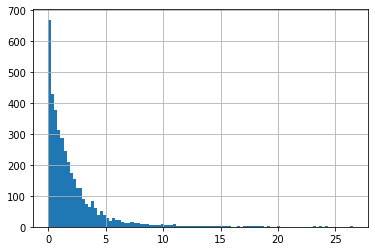

In [27]:
match = df_train["y_comparison"] == True
nonmatch = df_train["y_comparison"] == False
df_train["duration_dif"] = abs(df_train["duration"] - df_train["audio2_duration"]) 
df_train[match]["duration_dif"].hist(bins=100)

<AxesSubplot:>

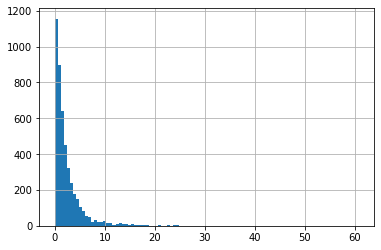

In [29]:
df_train[nonmatch]["duration_dif"].hist(bins=100)

In [31]:
df_train[nonmatch]["duration_dif"].max()

60.798874999999995

In [33]:
df_train[match]["duration_dif"].max()

26.494013605442177

In [43]:
df_val["duration_dif"] = abs(df_val["duration"] - df_val["audio2_duration"]) 
df_val[df_val["duration_dif"] > 20]

/home/ben/anaconda3/envs/pyannote/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,filenames,speaker_id,uri,path,y_true,audio2_path,audio2_label,audio2_uri,y_comparison,duration,audio2_duration,duration_dif
